# Multivariate Time Series Forecasting with LSTMs in Keras
#### Reference: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

#### Trained on a single Lag Timestep - All meters - No MeterNo - Negative & large values removed

In [1]:
from math import sqrt
from numpy import concatenate, savetxt, subtract
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat, Series
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 


In [3]:
# load dataset
#dataset = read_csv('DFS04690650Rand.txt', header=0, index_col=0)
dataset = read_csv('AllMonth.csv', header=0, sep='[,]', parse_dates=True, squeeze=True, dayfirst=True, engine='python') 
dataset.drop(dataset.columns[[0,2]], axis = 1, inplace = True)
values = dataset.values
print(dataset.head())
# ensure all data is float
values = values.astype('float32')
#drop any negatives
dataset = dataset.loc[dataset['kWh'] >= 0]
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.dtypes
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())
#shuffle rows
reframed=reframed.sample(frac=1).reset_index(drop=True)
print(reframed.head())

   kWh  DDH  Area_m2  Const_Year  Month
0  133  318     73.0        2007      1
1  182  311     73.0        2007      2
2  180  380     73.0        2007      3
3  157  254     73.0        2007      4
4   95  168     73.0        2007      5
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.045799   0.825352   0.294118        0.0   0.000000  0.062672
2   0.062672   0.805634   0.294118        0.0   0.090909  0.061983
3   0.061983   1.000000   0.294118        0.0   0.181818  0.054063
4   0.054063   0.645070   0.294118        0.0   0.272727  0.032713
5   0.032713   0.402817   0.294118        0.0   0.363636  0.017562
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
0   0.011019   0.090141   0.022624        0.0   0.454545  0.011708
1   0.121901   0.681690   0.378281        0.0   0.272727  0.090565
2   0.097796   0.152113   0.058824        0.0   0.727273  0.123623
3   0.025138   0.819718   0.031674        0.0   1.000000  0.032713
4   0.084366   0.078873

In [4]:
# split into train and test sets
values = reframed.values
n_train_periods = int(len(values)*0.8)
train = values[:n_train_periods, :]
test = values[n_train_periods:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(20464, 1, 5) (20464,) (5117, 1, 5) (5117,)


Epoch 1/50
427/427 - 4s - loss: 0.0335 - val_loss: 0.0224
Epoch 2/50
427/427 - 1s - loss: 0.0222 - val_loss: 0.0218
Epoch 3/50
427/427 - 1s - loss: 0.0217 - val_loss: 0.0214
Epoch 4/50
427/427 - 1s - loss: 0.0215 - val_loss: 0.0213
Epoch 5/50
427/427 - 1s - loss: 0.0215 - val_loss: 0.0211
Epoch 6/50
427/427 - 1s - loss: 0.0214 - val_loss: 0.0211
Epoch 7/50
427/427 - 1s - loss: 0.0213 - val_loss: 0.0211
Epoch 8/50
427/427 - 1s - loss: 0.0213 - val_loss: 0.0210
Epoch 9/50
427/427 - 1s - loss: 0.0213 - val_loss: 0.0211
Epoch 10/50
427/427 - 1s - loss: 0.0213 - val_loss: 0.0210
Epoch 11/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0211
Epoch 12/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0211
Epoch 13/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0211
Epoch 14/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0210
Epoch 15/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0210
Epoch 16/50
427/427 - 1s - loss: 0.0212 - val_loss: 0.0209
Epoch 17/50
427/427 - 1s - loss: 0.0211 - val_loss: 0.0210
Epoch 

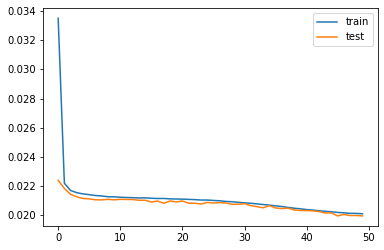

In [5]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=48, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.show()


In [6]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [10]:
# calculate actual kWh mean
actual_mean = dataset['kWh'].mean()
print('Actual Mean: %.3f' % actual_mean)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
# calculate MSE
#mse = mean_squared_error(inv_y, inv_yhat)
#print('Test MSE: %.3f' % mse)
# calculate mean % error
error_mean = round(rmse/actual_mean*100,2)
print('Percentage Error: %.3f' % error_mean)

Actual Mean: 295.316
Test RMSE: 111.140
Percentage Error: 37.630
